# Análisis de la etapa de generación de medios

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  
import plotly.express as px

## Armado del dataset

En este paso parsearemos los archivos para obtener estadísticas sobre el tiempo que tarda cada ejecución de una función, sobre la memoria usada, el uso de CPU. Con esto buscamos identificar:
- Qué funciones son las que consumen mayor cantidad de memoria
- Qué funciones son las que tienen un mayor tiempo de procesamiento
- Qué funciones son las que son invocadas una mayor cantidad de veces

Una vez identificados estos puntos de análisis podemos proponer soluciones para mejorar estas estadísticas.

In [2]:
def get_function_name(function_name):
    return function_name[10:].rsplit(".c")[0]

In [3]:
relations = {
    "Py_kgeneration": ['generate', 'fftma2'],
    "generate": ["gasdev"],
    "gasdev": ["ran2"],
    "fftma2": ["covariance", "fourt", "prebuild_gwn"]
}
functions = ['Py_kgeneration', 'generate', 'fftma2', 'covariance', 'gasdev', 'fourt', 'cov_value', 'ran2', 'build_real', 'prebuild_gwn', 'clean_real', 'cgrid', 'length', 'maxfactor']
overall_time = {}
overall_memory = {}

In [4]:
def get_data(file_name):
    data = []
    row = {}

    with open(file_name) as log_file:
        lines = log_file.readlines()
        for line in lines:
            split_line = line.split()
                
            if "USED" not in split_line and "ELAPSED" not in split_line and "CPU" not in split_line: continue
    
            if "CPU" in split_line:
                idx_cpu = split_line.index("CPU") + 1
                idx_per = idx_cpu + 1
                row["cpu"] = row.get('cpu', [])
                row["cpu"].append(float(split_line[idx_per].rsplit("%")[0]))
                continue
                
            idx_used_mem = split_line.index("USED") + 4
            idx_elapsed = split_line.index("ELAPSED") + 2
            
            function_name = get_function_name(split_line[2])
                        
            used_virtual_mem = float(split_line[idx_used_mem])
            elapsed = float(split_line[idx_elapsed].rsplit(",")[0])

            row["function"] = function_name
            row["memory"] = used_virtual_mem 
            row["time"] = elapsed
            if "cpu" in row:
                if row["function"] == "generate": print(row["cpu"])
                row["cpu"] = sum(row["cpu"]) / len(row["cpu"])
            data.append(row)
            row = {}
            
    return data

In [5]:
def create_df(file_name):
    data = get_data(file_name)
    df = pd.DataFrame(data)
    return df.groupby(['function']).agg({'time': ['min', 'max', 'mean', 'sum', 'count'], 'memory': ['min', 'max', 'median'], 'cpu': ['min', 'max', 'mean']})

In [6]:
def analyze(file_name):
    df_grouped = create_df(file_name)
    return df_grouped.sort_values(by=('time', 'sum'), ascending=False)                

In [7]:
def merge_dfs(dfs):
    df_final = pd.concat(dfs, join='inner').sort_values(by=('time', 'sum'), ascending=False) 

    memory_min, memory_max, memory_median = [], [], []
    time_min, time_max, time_mean, time_sum, time_count = [], [], [], [], []
    cpu_min, cpu_max, cpu_mean = [], [], []

    for function in functions:
        memory_min.append(df_final.loc[function, ('memory', 'min')].min())
        time_min.append(df_final.loc[function, ('time', 'min')].min())
        cpu_min.append(df_final.loc[function, ('cpu', 'min')].min())
        memory_max.append(df_final.loc[function, ('memory', 'max')].max())
        time_max.append(df_final.loc[function, ('time', 'max')].max())
        cpu_max.append(df_final.loc[function, ('cpu', 'max')].max())
        time_mean.append(df_final.loc[function, ('time', 'mean')].mean())
        cpu_mean.append(df_final.loc[function, ('cpu', 'mean')].mean())
        time_sum.append(df_final.loc[function, ('time', 'sum')].sum())
        time_count.append(df_final.loc[function, ('time', 'count')].sum())
        try:
            memory_median.append(df_final.loc[function, ('memory', 'median')].median())
        except:
            memory_median.append(df_final.loc[function, ('memory', 'median')])
        
    df = pd.DataFrame({('memory', 'min'): memory_min, ('memory', 'max'): memory_max, ('memory', 'median'): memory_median, ('time', 'min'): time_min, ('time', 'max'): time_max, ('time', 'mean'): time_mean, ('time', 'sum'): time_sum, ('time', 'count'): time_count, ('cpu', 'min'): cpu_min, ('cpu', 'max'): cpu_max, ('cpu', 'mean'): cpu_mean})

    df.index = functions
    df.index.name = 'function'
    return df

In [8]:
def analyze(file_names):
    if len(file_names) == 1:
        df_grouped = create_df(file_names[0])
        return df_grouped.sort_values(by=('time', 'sum'), ascending=False)
    else:
        dfs = []
        for file_name in file_names:
            print("Executing file {}".format(file_name))
            df = create_df(file_name)
            dfs.append(df)
        return merge_dfs(dfs)

In [9]:
def plot_pie(df, function, plt, column):
    
    labels = relations[function][:]
    total = abs(df.loc[function][column])
    sizes = []
    explode = []

    rest = total

    for func in labels:
        func_duration = abs(df.loc[func][column])
        rest -= func_duration
        value = func_duration/ total
        sizes.append(value)
        explode.append(0 if value > 0.01 else 0.1)

    
    if rest > 0:
        labels.append("other")
        sizes.append(rest/total)
        explode.append(0 if rest/total > 0.01 else 0.1)
    sizes = np.array(sizes)
    porcent = 100.*sizes/sizes.sum()
    

    if not np.isnan(sizes).all():
    
        plt.set_title(function)

        patches, texts = plt.pie(sizes, startangle=90, radius=1.2)
        labels_formated = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]

        sort_legend = True
        if sort_legend:
            patches, labels_formated, dummy =  zip(*sorted(zip(patches, labels_formated, sizes),
                                                  key=lambda x: x[2],
                                                  reverse=True))

        plt.legend(patches, labels_formated, loc='upper left', bbox_to_anchor=(-0.1, 1.),
                   fontsize=8)

        plt.axis('equal')

def plot_pie_charts(df, title, column):
    fig, axs = plt.subplots(2, 2, dpi=100, figsize=(6, 6))
    fig.suptitle(title)
    functions = list(relations.keys())
    for i in range(2):
        for j in range(2):
            plot_pie(df,functions[2*i + j], axs[i, j], column)
    

In [10]:
parents = {
    "Py_kgeneration": "",
    "generate": "Py_kgeneration",
    "gasdev": "generate",
    "fftma2":  "Py_kgeneration",
    "covariance": "fftma2",
    "fourt": "fftma2",
    "prebuild_gwn": "fftma2",
    "ran2": "gasdev",
    "cov_value": "covariance",
}

def plot_treemap(df, column, name, title):
    df["parent"] = [parents.get(item, "") for item in df.index]
    df2 = df.reset_index()
    df2[name] = df2[[column]]
    df2 = df2[["function", "parent", name]]
    fig3 = px.treemap(df2, names='function', parents='parent',values=name, color="parent", title=title)
    fig3.show()

## N = 8

### Armado del dataset

In [100]:
df = analyze(['log_8-aa'])
overall_time["8"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["8"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

[32.388401, 20.1, 100.1, 5.228205, 5.363158, 5.1, 12.295122, 100.1]


memory                    cpu                            time  \
                  min  max median        min        max       mean       min   
function                                                                       
Py_kgeneration    1.2  1.2    1.2  34.560105  34.560105  34.560105  0.633546   
generate          1.3  1.3    1.3  35.084361  35.084361  35.084361  0.397899   
gasdev           -0.2  0.2    0.0   0.000000  62.562500   2.701072  0.000106   
fftma2           -0.1 -0.1   -0.1  32.746141  32.746141  32.746141  0.234361   
covariance       -0.1 -0.1   -0.1  33.296729  33.296729  33.296729  0.224350   
cov_value        -0.2  0.2    0.0   0.000000  37.537500   0.925280  0.000103   
ran2             -0.2  0.2    0.0   0.000000  25.037500   0.699745  0.000101   
fourt             0.0  0.0    0.0   0.000000   0.012500   0.004167  0.000553   
cgrid             0.0  0.0    0.0   0.000000   0.000000   0.000000  0.001623   
length            0.0  0.0    0.0   0.000000   0.000000   0.000000  0.000355   
clean_real        0.0  0.0    0.0   0.000000   0.000000   0.000000  0.000463   
prebuild_gwn      0.0  0.0    0.0  25.025000  25.025000  25.025000  0.000454   
build_real        0.0  0.0    0.0   0.000000   0.000000   0.000000  0.000410   
maxfactor         0.0  0.0    0.0   0.000000   0.000000   0.000000  0.000105   

                                                    
                     max      mean       sum count  
function                                            
Py_kgeneration  0.633546  0.633546  0.633546     1  
generate        0.397899  0.397899  0.397899     1  
gasdev          0.007636  0.000579  0.296354   512  
fftma2          0.234361  0.234361  0.234361     1  
covariance      0.224350  0.224350  0.224350     1  
cov_value       0.000966  0.000134  0.093502   700  
ran2            0.000583  0.000133  0.093435   702  
fourt           0.000795  0.000664  0.001993     3  
cgrid           0.001623  0.001623  0.001623     1  
length          0.000359  0.000358  0.001073     3  
clean_real      0.000463  0.000463  0.000463     1  
prebuild_gwn    0.000454  0.000454  0.000454     1  
build_real      0.000410  0.000410  0.000410     1  
maxfactor       0.000106  0.000105  0.000316     3

### Comparación de tiempos

Una vez reconocidas qué funciones llaman a otras, se muestra en los siguientes gráficos cuánto tiempo consume cada función respecto del total que insume la función invocante.

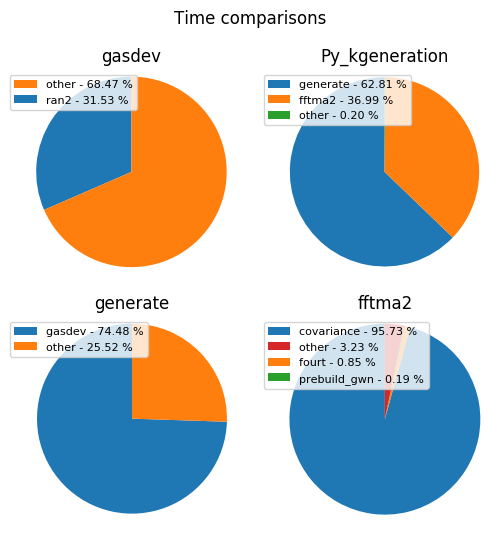

In [101]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

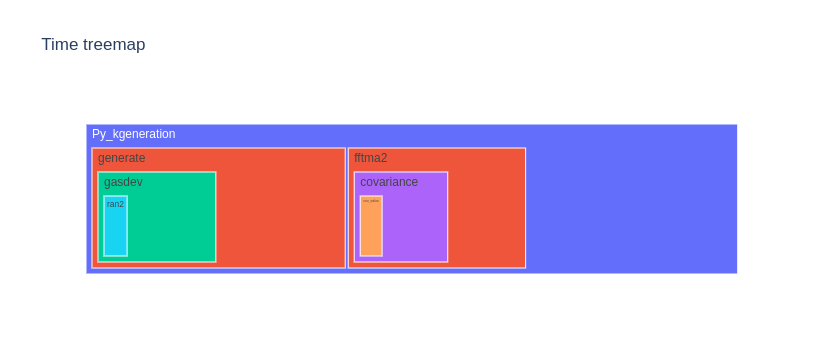

In [102]:
plot_treemap(df, ("time", "sum"), "time_sum", "Time treemap")

### Comparación de memoria

Una vez reconocidas qué funciones llaman a otras, se muestra en los siguientes gráficos cuánta memoria consume cada función respecto del total que insume la función invocante.

/home/cecix/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



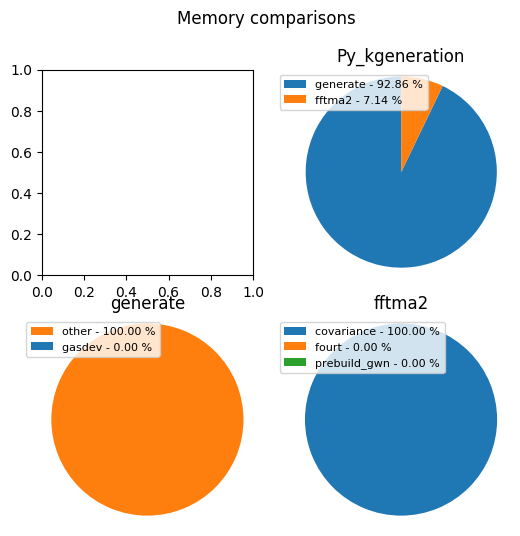

In [103]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

### Análisis de la CPU

Se busca en los siguientes gráficos mostrar cómo evoluciona el uso de la CPU a lo largo de las distintas configuraciones.

El gráfico se hizo en base al promedio de uso en la CPU de todos los cores disponibles (8 en nuestras computadoras).

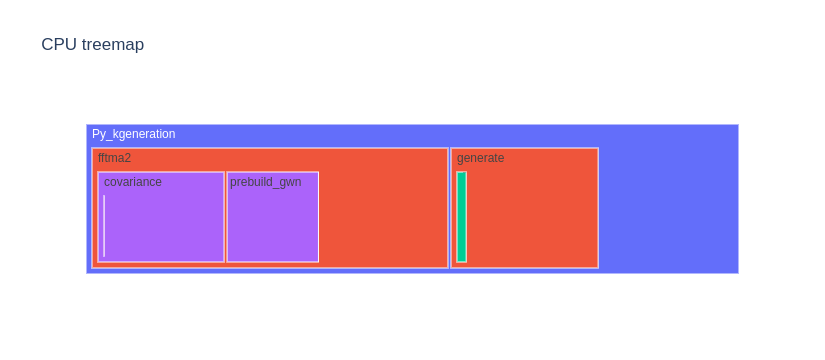

In [105]:
plot_treemap(df, ("cpu", "mean"), "cpu_mean", "CPU treemap")

## N = 16

### Armado del dataset

In [106]:
df = analyze(['log_16-aa'])
overall_time["16"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["16"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

[37.258909, 28.809677, 18.546602, 56.649521, 38.561538, 36.02233, 59.715385, 41.633546]


memory                     cpu                         \
                  min   max median        min         max       mean   
function                                                               
Py_kgeneration  -21.2 -21.2  -21.2  36.171001   36.171001  36.171001   
generate        -20.0 -20.0  -20.0  39.649689   39.649689  39.649689   
gasdev          -23.9   3.0    0.0   0.000000  100.100000   3.056432   
fftma2           -1.2  -1.2   -1.2  27.218459   27.218459  27.218459   
covariance       -1.2  -1.2   -1.2  26.980180   26.980180  26.980180   
ran2             -9.1   1.3    0.0   0.000000   50.050000   0.782603   
cov_value        -3.8   0.9    0.0   0.000000   43.800000   0.578152   
fourt             0.0   0.0    0.0   0.000000   50.050000  16.687500   
cgrid             0.0   0.0    0.0   0.025000    0.025000   0.025000   
length            0.0   0.0    0.0   0.000000    0.012500   0.008333   
maxfactor         0.0   0.0    0.0   0.000000    0.012500   0.004167   
build_real        0.0   0.0    0.0   0.000000    0.000000   0.000000   
prebuild_gwn      0.0   0.0    0.0   0.000000    0.000000   0.000000   
clean_real        0.0   0.0    0.0   0.000000    0.000000   0.000000   

                    time                                      
                     min       max      mean       sum count  
function                                                      
Py_kgeneration  4.518677  4.518677  4.518677  4.518677     1  
generate        3.283041  3.283041  3.283041  3.283041     1  
gasdev          0.000099  0.121965  0.000595  2.437584  4096  
fftma2          1.231253  1.231253  1.231253  1.231253     1  
covariance      1.223604  1.223604  1.223604  1.223604     1  
ran2            0.000095  0.001958  0.000135  0.710129  5268  
cov_value       0.000101  0.001366  0.000137  0.488994  3564  
fourt           0.000824  0.001123  0.000944  0.002831     3  
cgrid           0.001635  0.001635  0.001635  0.001635     1  
length          0.000352  0.000360  0.000356  0.001069     3  
maxfactor       0.000103  0.000112  0.000106  0.000318     3  
build_real      0.000274  0.000274  0.000274  0.000274     1  
prebuild_gwn    0.000267  0.000267  0.000267  0.000267     1  
clean_real      0.000217  0.000217  0.000217  0.000217     1

### Comparación de tiempos

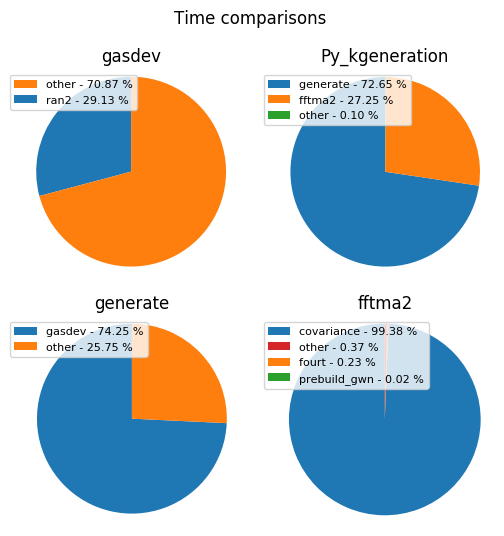

In [107]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

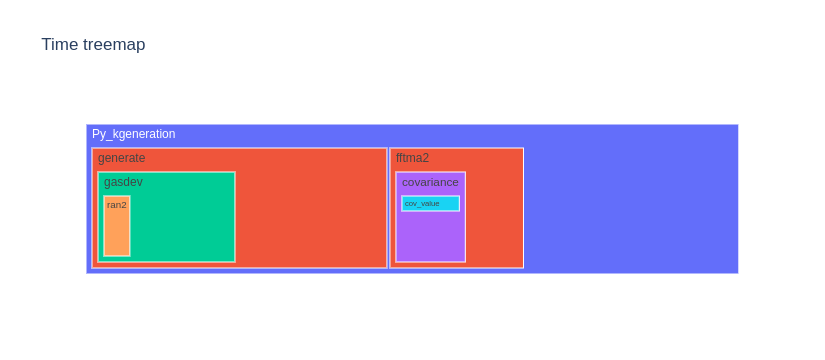

In [108]:
plot_treemap(df, ("time", "sum"), "time_sum", "Time treemap")

### Comparación de memoria

/home/cecix/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



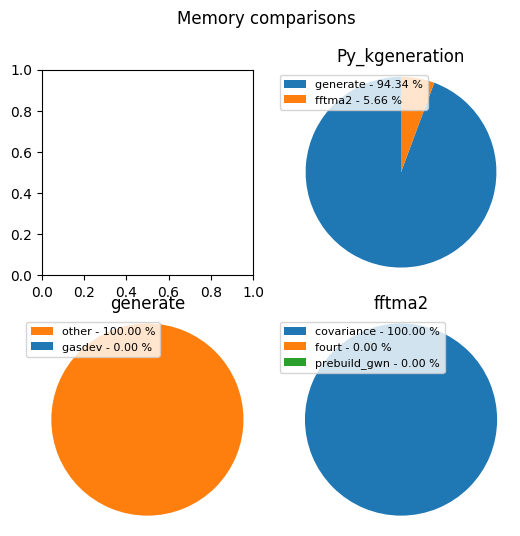

In [109]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

### Análisis de la CPU

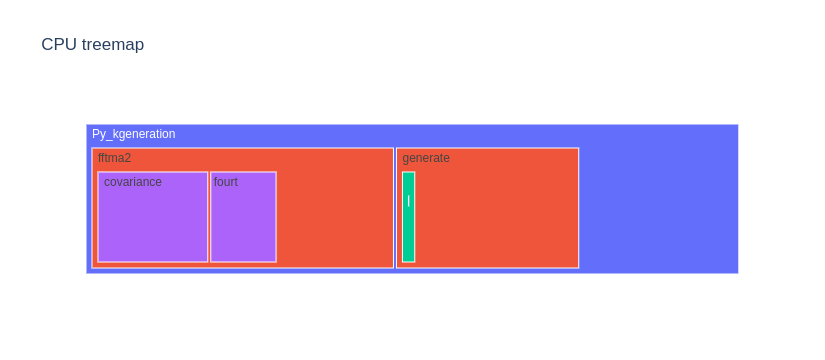

In [110]:
plot_treemap(df, ("cpu", "mean"), "cpu_mean", "CPU treemap")

## N = 32

### Armado del dataset

In [113]:
df = analyze(['log_32-aa'])
overall_time["32"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["32"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

[34.959155, 12.878561, 60.414342, 35.334899, 71.344033, 39.886457, 18.975958, 23.163878]


memory                      cpu                        \
                  min    max median        min        max       mean   
function                                                               
Py_kgeneration  240.1  240.1  240.1  36.513030  36.513030  36.513030   
generate        197.0  197.0  197.0  37.119660  37.119660  37.119660   
gasdev          -14.9    6.5    0.0   0.000000  75.087500   3.952230   
fftma2           43.1   43.1   43.1  34.781175  34.781175  34.781175   
covariance       42.6   42.6   42.6  34.788296  34.788296  34.788296   
ran2             -7.1    2.6    0.0   0.000000  62.562500   1.048878   
cov_value        -4.1    2.5    0.0   0.000000  62.562500   1.028264   
fourt             0.0    0.0    0.0  15.100000  30.062500  20.900000   
cgrid             0.0    0.0    0.0  29.216667  29.216667  29.216667   
length            0.0    0.0    0.0   0.000000  37.550000  12.520833   
maxfactor         0.0    0.0    0.0   0.000000  25.025000   5.007500   
prebuild_gwn      0.5    0.5    0.5   0.012500   0.012500   0.012500   
build_real        0.0    0.0    0.0   0.012500   0.012500   0.012500   
clean_real        0.0    0.0    0.0   0.012500   0.012500   0.012500   

                     time                                          
                      min        max       mean        sum  count  
function                                                           
Py_kgeneration  47.638534  47.638534  47.638534  47.638534      1  
generate        35.573628  35.573628  35.573628  35.573628      1  
gasdev           0.000098   0.017469   0.000797  26.105193  32768  
fftma2          12.060570  12.060570  12.060570  12.060570      1  
covariance      12.036319  12.036319  12.036319  12.036319      1  
ran2             0.000094   0.001763   0.000191   7.933390  41552  
cov_value        0.000181   0.000461   0.000199   4.906137  24624  
fourt            0.004642   0.006769   0.005419   0.016257      3  
cgrid            0.003691   0.003691   0.003691   0.003691      1  
length           0.000633   0.001058   0.000914   0.002742      3  
maxfactor        0.000179   0.000185   0.000182   0.000910      5  
prebuild_gwn     0.000599   0.000599   0.000599   0.000599      1  
build_real       0.000510   0.000510   0.000510   0.000510      1  
clean_real       0.000403   0.000403   0.000403   0.000403      1

### Comparación de tiempos

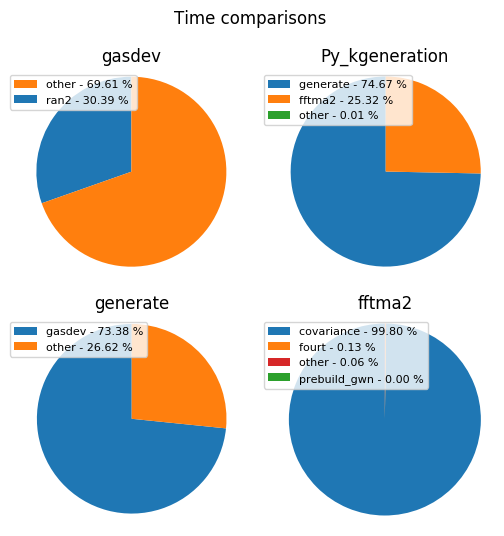

In [114]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

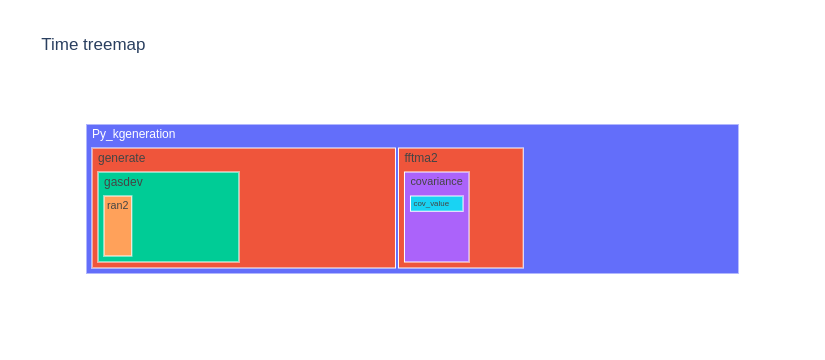

In [115]:
plot_treemap(df, ("time", "sum"), "time_sum", "Time treemap")

### Comparación de memoria

/home/cecix/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



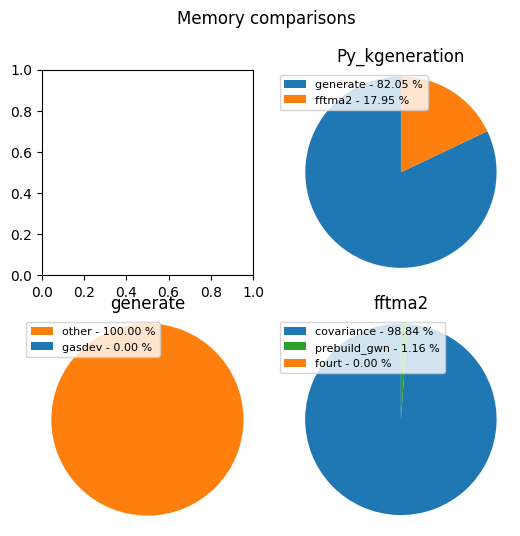

In [116]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

### Análisis de la CPU

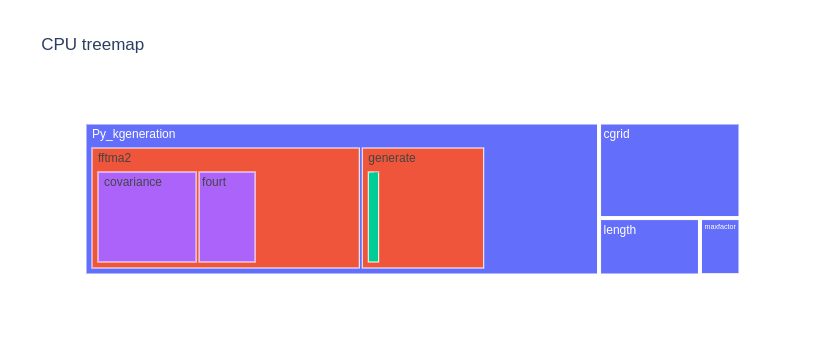

In [117]:
plot_treemap(df, ("cpu", "mean"), "cpu_mean", "CPU treemap")

## N = 64

### Armado del dataset

In [118]:
df = analyze(['log_64-aa', 'log_64-ab'])
overall_time["64"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["64"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

Executing file log_64-aa
Executing file log_64-ab
[39.241055, 42.262603, 56.511493, 42.525066, 42.717744, 35.235135, 28.406878, 32.749276]


cpu                       memory                \
                       max       mean        min    max median    min   
function                                                                
Py_kgeneration   39.623390  39.623390  39.623390 -199.3 -199.3 -199.3   
generate         39.956156  39.956156  39.956156 -281.6 -281.6 -281.6   
fftma2           38.343737  38.343737  38.343737   85.3   85.3   85.3   
covariance       38.374862  38.374862  38.374862   80.9   80.9   80.9   
gasdev          100.100000   4.585812   0.000000    8.0    0.0  -61.2   
fourt            26.647619  21.861514  18.985732    2.3    0.4   -0.2   
cov_value        62.575000   1.210890   0.000000    3.0    0.0   -7.1   
ran2             75.087500   1.219338   0.000000    2.7    0.0  -17.8   
build_real        0.012500   0.012500   0.012500    0.0    0.0    0.0   
prebuild_gwn      0.025000   0.025000   0.025000    2.2    2.2    2.2   
clean_real        6.287500   6.287500   6.287500    0.4    0.4    0.4   
cgrid             0.025000   0.025000   0.025000    0.0    0.0    0.0   
length            0.012500   0.008333   0.000000    0.0    0.0    0.0   
maxfactor         0.012500   0.006250   0.000000    0.0    0.0    0.0   

                    time                                                  
                   count         max        mean         min         sum  
function                                                                  
Py_kgeneration       1.0  415.639768  415.639768  415.639768  415.639768  
generate             1.0  329.579564  329.579564  329.579564  329.579564  
fftma2               1.0   86.059132   86.059132   86.059132   86.059132  
covariance           1.0   85.894170   85.894170   85.894170   85.894170  
gasdev          262144.0    0.011277    0.000909    0.000193  242.610944  
fourt                3.0    0.066393    0.050588    0.042309    0.151763  
cov_value       156816.0    0.000575    0.000221    0.000193   34.674709  
ran2            333450.0    0.000691    0.000218    0.000190   74.079918  
build_real           1.0    0.001935    0.001935    0.001935    0.001935  
prebuild_gwn         1.0    0.002618    0.002618    0.002618    0.002618  
clean_real           1.0    0.001551    0.001551    0.001551    0.001551  
cgrid                1.0    0.003504    0.003504    0.003504    0.003504  
length               3.0    0.001141    0.000827    0.000668    0.002481  
maxfactor            4.0    0.000198    0.000195    0.000193    0.000780

### Comparación de tiempos

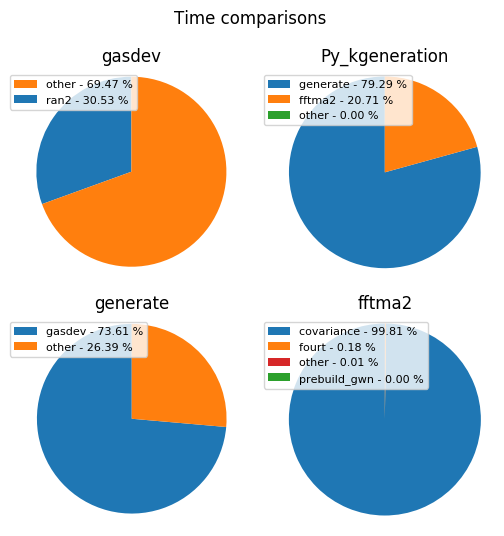

In [119]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

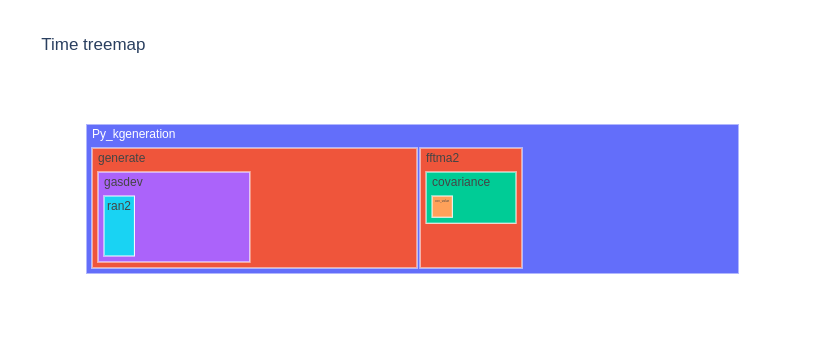

In [120]:
plot_treemap(df, ("time", "sum"), "time_sum", "Time treemap")

### Comparación de memoria

/home/cecix/.local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



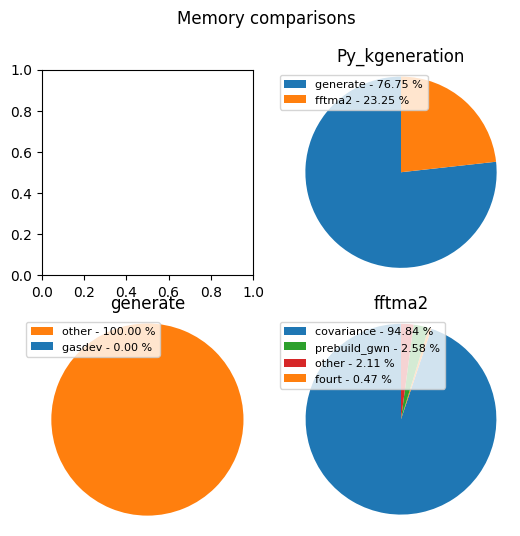

In [121]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

### Análisis de la CPU

In [122]:
plot_treemap(df, ("cpu", "mean"), "cpu_mean", "CPU treemap")

## N = 128

### Armado del dataset

In [ ]:
df = analyze(['log_128-aa', 'log_128-ab', 'log_128-ac', 'log_128-ad', 'log_128-ae', 'log_128-af', 'log_128-ag', 'log_128-ah', 'log_128-ai', 'log_128-aj', 'log_128-ak'])
overall_time["128"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["128"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

Executing file log_128-aa
Executing file log_128-ab
Executing file log_128-ac


### Comparación de tiempo

In [ ]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

In [ ]:
plot_treemap(df, ("time", "sum"), "time_sum", "Time treemap")

### Comparación de memoria

In [ ]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

### Análisis de la CPU

In [ ]:
plot_treemap(df, ("cpu", "mean"), "cpu_mean", "CPU treemap")

## N = 256

### Armado del dataset

In [94]:
df = analyze(['log_256-aa', 'log_256-ab', 'log_256-ac'])
overall_time["256"] = df.loc["Py_kgeneration"][("time", "sum")]
overall_memory["256"] = abs(df.loc["Py_kgeneration"][("memory", "median")])
df

Executing file number 1 out of 10
Executing file number 2 out of 10
Executing file number 3 out of 10
Executing file number 4 out of 10
Executing file number 5 out of 10
Executing file number 6 out of 10
Executing file number 7 out of 10
Executing file number 8 out of 10
Executing file number 9 out of 10
Executing file number 10 out of 10


In [96]:
merge_dfs(dfs)

memory                        time                            \
                   max  median     min       count          max         mean   
function                                                                       
Py_kgeneration  7421.6  7421.6  7421.6         1.0  1226.822575  1226.822575   
generate        6691.7  6691.7  6691.7         1.0   959.799368   959.799368   
fftma2           872.0   872.0   872.0         1.0   267.021516   267.021516   
covariance       870.5   870.5   870.5         1.0   247.512194   247.512194   
gasdev             8.7     0.0   -13.5  16777216.0     0.001358     0.000033   
fourt             11.5    -1.4   -16.2         3.0     8.429829     6.378454   
cov_value          0.7     0.0   -13.9   8855600.0     0.000437     0.000002   
ran2               0.9     0.0    -0.8  21359556.0     0.000381     0.000002   
build_real        -0.2    -0.2    -0.2         1.0     0.151968     0.151968   
prebuild_gwn       6.5     6.5     6.5         1.0     0.108160     0.108160   
clean_real       127.2   127.2   127.2         1.0     0.095267     0.095267   
cgrid              0.0     0.0     0.0         1.0     0.000160     0.000160   
length             0.0     0.0     0.0         3.0     0.000043     0.000034   
maxfactor          0.0     0.0     0.0         5.0     0.000002     0.000002   

                                          
                        min          sum  
function                                  
Py_kgeneration  1226.822575  1226.822575  
generate         959.799368   959.799368  
fftma2           267.021516   267.021516  
covariance       247.512194   247.512194  
gasdev             0.000000   564.182445  
fourt              5.015006    19.135362  
cov_value          0.000001    21.579349  
ran2               0.000000    45.002553  
build_real         0.151968     0.151968  
prebuild_gwn       0.108160     0.108160  
clean_real         0.095267     0.095267  
cgrid              0.000160     0.000160  
length             0.000021     0.000102  
maxfactor          0.000001     0.000008

### Comparación de tiempos

In [ ]:
plot_pie_charts(df, "Time comparisons", ("time", "sum"))

In [ ]:
plot_treemap(df, ("time", "sum"), "time_sum")

### Comparación de memoria

In [ ]:
plot_pie_charts(df, "Memory comparisons", ("memory", "median"))

### Análisis de la CPU

In [ ]:
plot_treemap(df, ("cpu", "mean"), "cpu_mean", "CPU treemap")

## Tiempo insumido con distintos N

Se busca mostrar en los siguientes gráficos la relación exponencial que existe entre el tiempo insumido por cada una de las configuraciones de distinto N.

In [94]:
def plot_overall_comparison(info, title, unit):
    fig = plt.figure()
    plt.title(title)
    plt.bar(info.keys(),info.values())
    plt.ylabel(unit)
    plt.xlabel("sizes")
    plt.show()

{'8': 0.544398, '16': 2.908668, '32': 22.135483, '64': 178.629961}


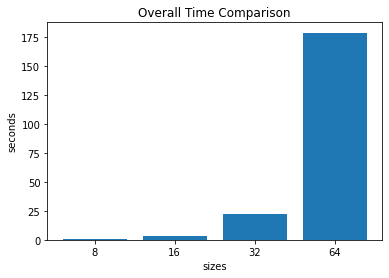

In [95]:
print(overall_time)
plot_overall_comparison(overall_time, "Overall Time Comparison", "seconds")

{'8': 0.2, '16': 11.1, '32': 53.6, '64': 304.2}


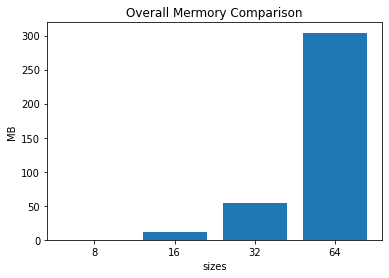

In [97]:
print(overall_memory)
plot_overall_comparison(overall_memory, "Overall Mermory Comparison", "MB")

## Identificación de valores usados en las funciones más invocadas

Con los gráficos de las secciones anteriores es posible identificar qué funciones son las que son llamadas una mayor cantidad de veces: `gasdev`, `cov_value` y `ran2`. 

El objetivo de esta sección es analizar con qué valores se llaman a estas funciones para identificar patrones y diferencias.

In [20]:
functions_repeated = {
    "gasdev":["idum", "idum2", "iy"],
    "cov_value": ["di", "dj", "dk"],
    "ran2": ["idum", "idum2", "iy"],
}

def get_data_from_file(file_name):
    data = {
        "gasdev": {"idum": [], "idum2": [], "iy": []},
        "ran2": {"idum": [], "idum2": [], "iy": []},
        "cov_value": {"di":[], "dj": [], "dk": []}
    }
    
    return_values = {
        "gasdev": [],
        "ran2": [],
        "cov_value": []
    }

    with open(file_name) as log_file:
        lines = log_file.readlines()
        for line in lines:
            if np.any([f in line for f in functions_repeated.keys()]) and "RESULT = in progress" in line:
                split_line = line.split()
                function_name = get_function_name(split_line[2])
                params = functions_repeated[function_name]
                for p in params:
                    idx_value = split_line.index(p) + 2
                    data[function_name][p].append(float(split_line[idx_value].rsplit(",")[0]))
                    
            elif np.any([f in line for f in functions_repeated.keys()]) and "RESULT = success" in line:
                split_line = line.split()
                function_name = get_function_name(split_line[2])
                return_values[function_name].append(float(split_line[8].rsplit(",")[0]))
    return data, return_values

def get_repeteated_data(filenames):
    data_total = {}
    return_total = {}
    for f in filenames:
        data, return_values = get_data_from_file(f)
        data_total = {**data_total, **data}
        return_total = {**return_total, **return_values}
    return data_total, return_total

In [12]:
def distribution(data,f, p, plt):
    values = data[f][p]
    if np.isnan(values).all(): return # TODO: Pasa algo raro con gasdev iy en 32
    plt.set_title(f"{p}")
    plt.hist(values, bins=60, alpha=1, edgecolor = 'black',  linewidth=1)
    plt.grid(True)
    plt.set_ylabel("Number of repetitions")
    plt.set_xlabel("value")

def plot_distributions(data, f):
    fig, axs = plt.subplots(2, 2, dpi=100, figsize=(6, 6))
    fig.suptitle(f"Distribution in params for {f}")
    params = list(data[f].keys())
    for i in range(2):
        for j in range(2):
            if 2*i + j < len(params):
                distribution(data, f,params[2*i + j], axs[i, j])
                
    
    fig.delaxes(axs[1, 1])
    fig.tight_layout(pad=3.0)

In [21]:
def plot_reapeated_data_distribution(data):
    for f in functions_repeated.keys():
        plot_distributions(data,f)

In [23]:
def plot_return_values_dist(return_values):
    for f in return_values.keys():
        
        fig = plt.figure()
        plt.title(f"Distribution of {f} return value")
        plt.hist(return_values[f], bins=60, alpha=1, edgecolor = 'black',  linewidth=1)
        plt.grid(True)
        plt.ylabel("Number of repetitions")
        plt.xlabel("value")
        plt.show()

## N = 8

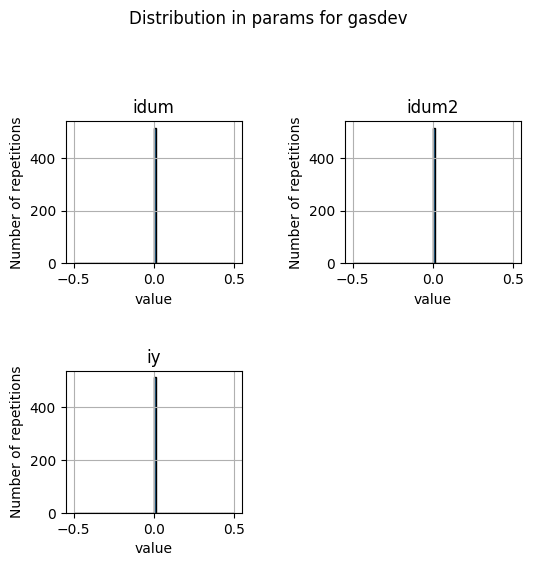

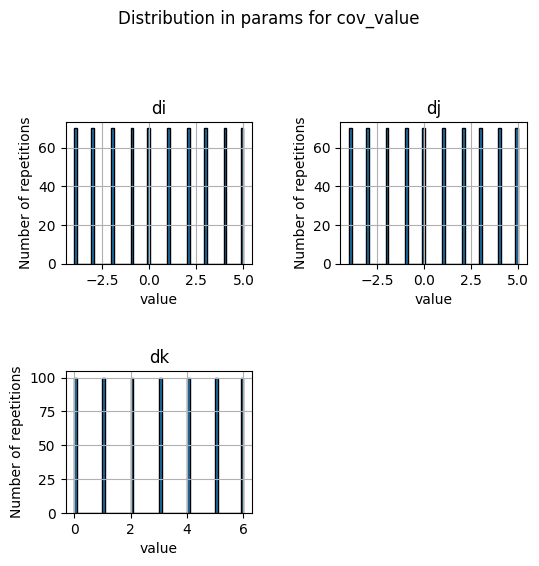

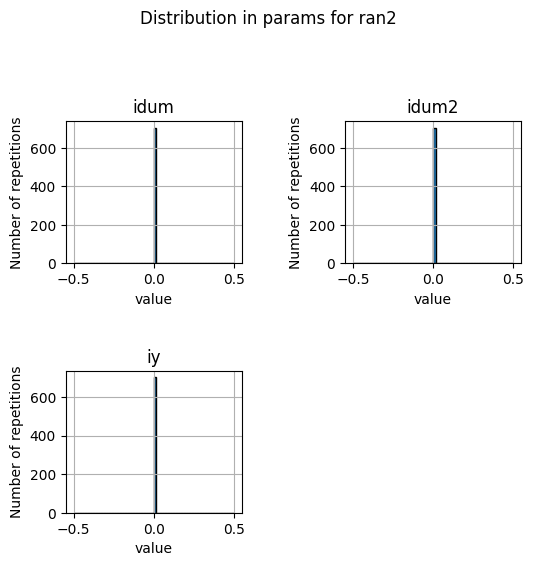

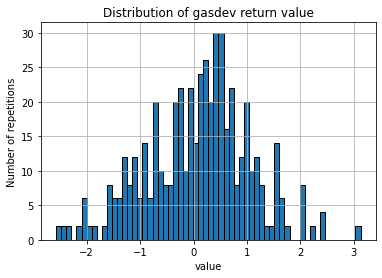

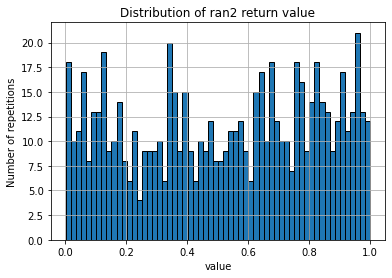

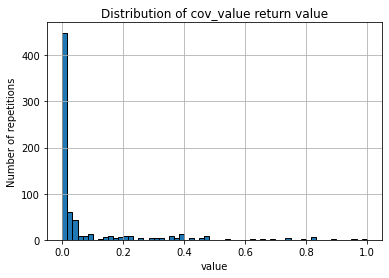

In [26]:
data, return_values = get_repeteated_data(['log_8-aa'])
plot_reapeated_data_distribution(data)
plot_return_values_dist(return_values)

## N = 16

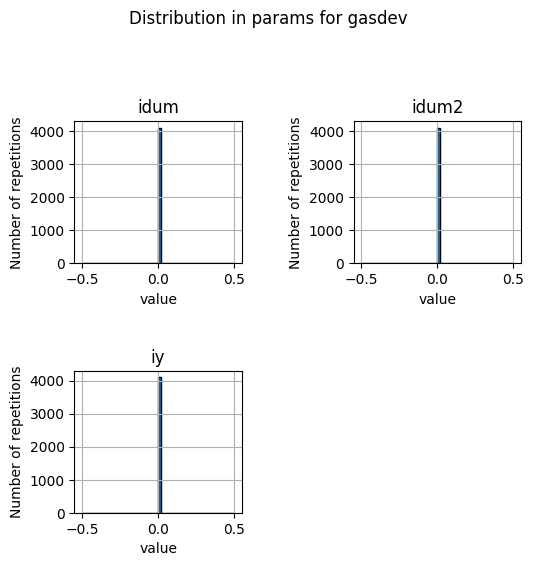

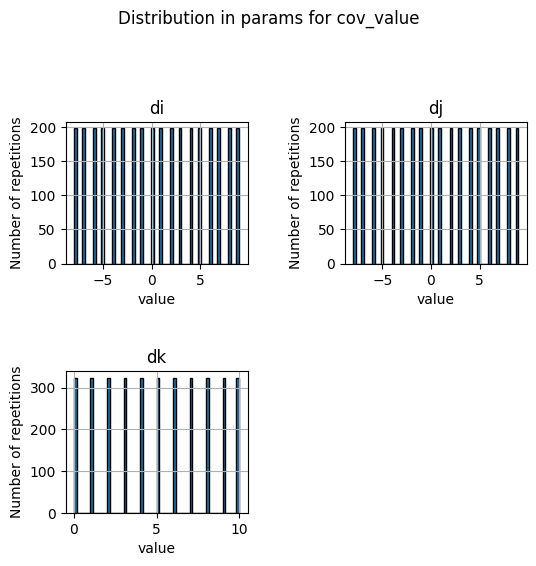

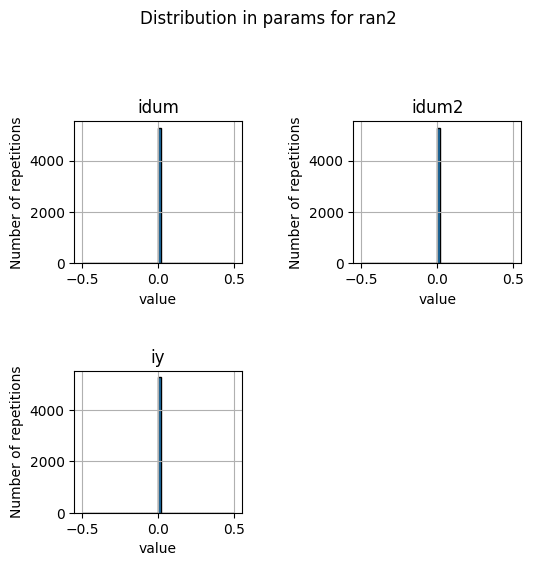

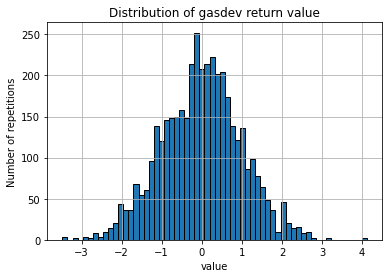

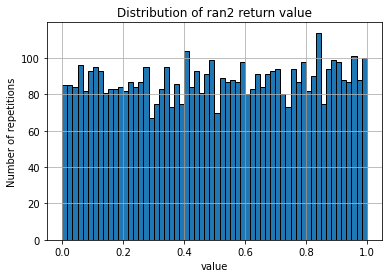

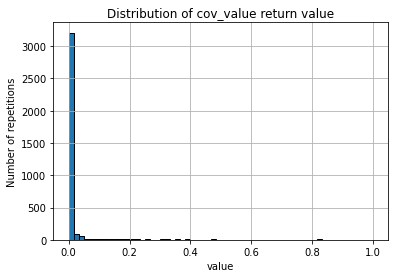

In [27]:
data, return_values = get_repeteated_data(['log_16-aa'])
plot_reapeated_data_distribution(data)
plot_return_values_dist(return_values)

## N = 32

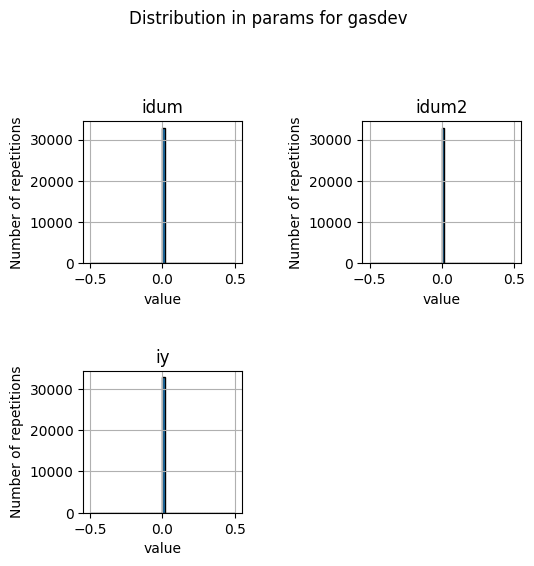

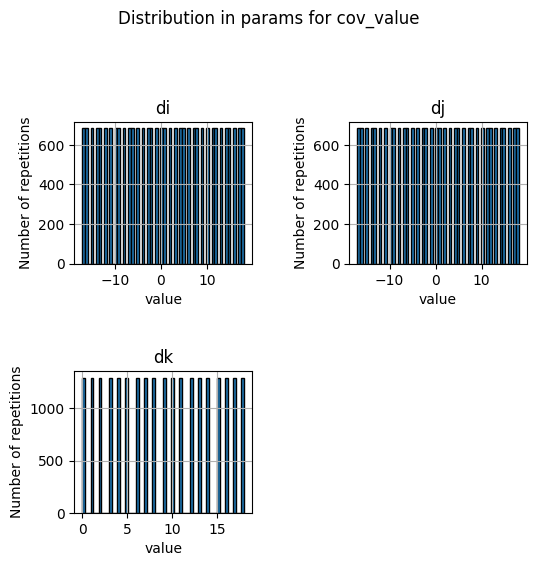

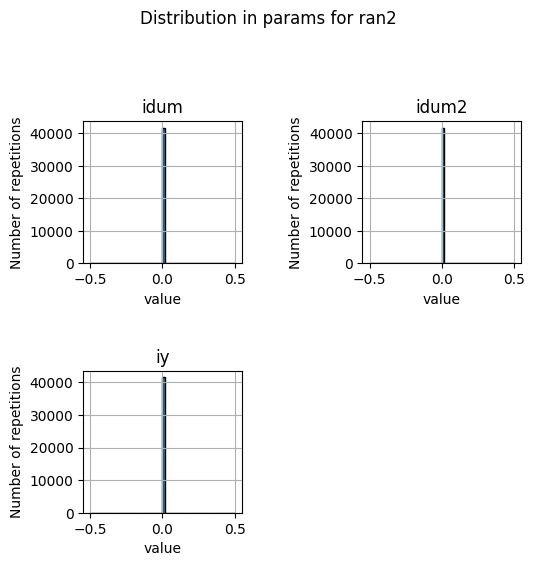

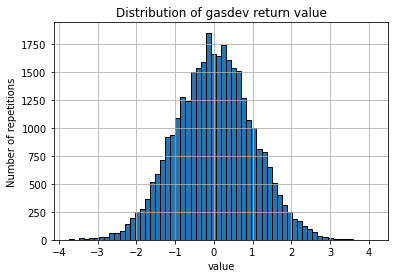

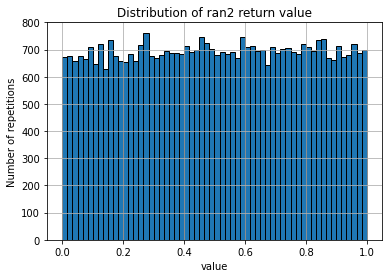

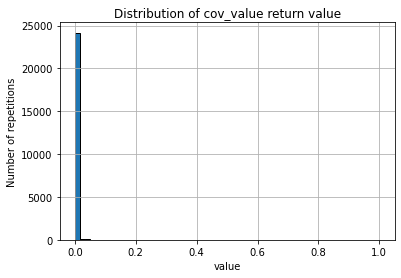

In [25]:
data, return_values = get_repeteated_data(['log_32-aa'])
plot_reapeated_data_distribution(data)
plot_return_values_dist(return_values)

## N = 64

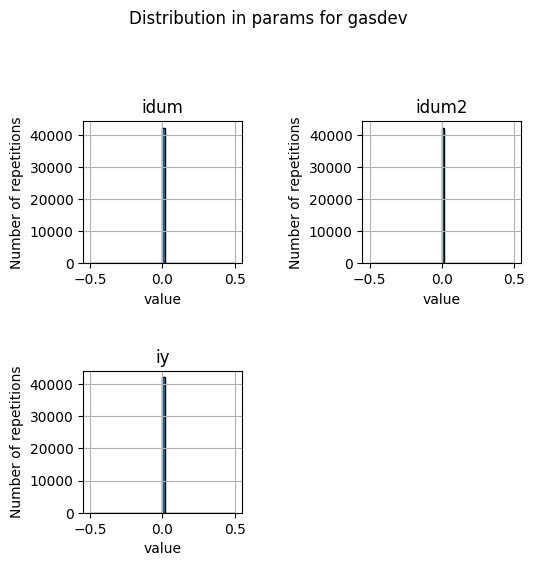

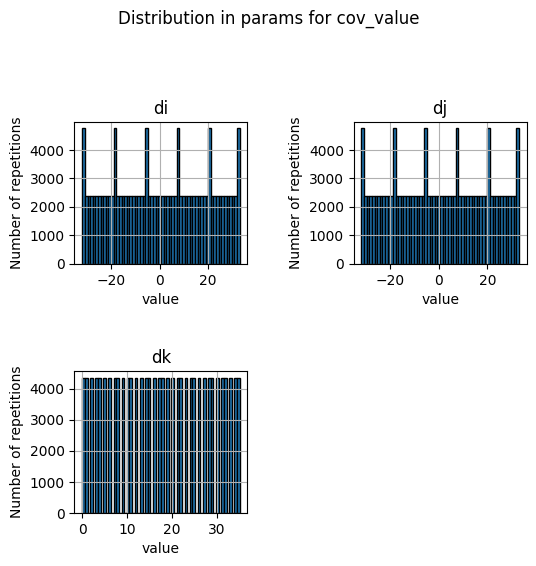

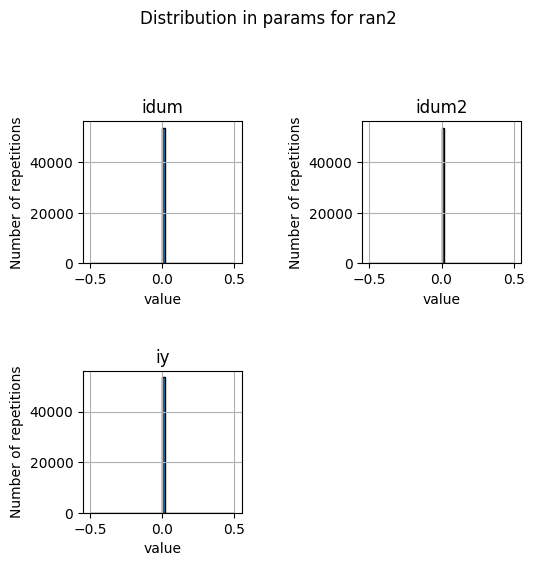

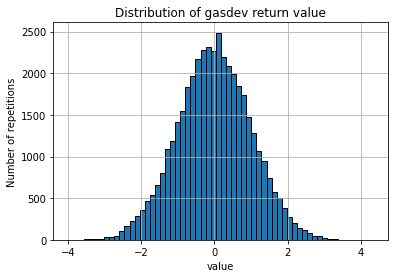

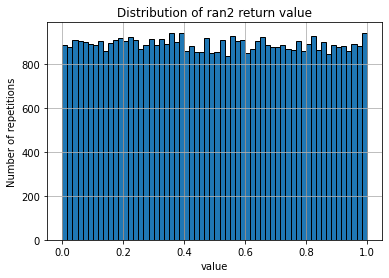

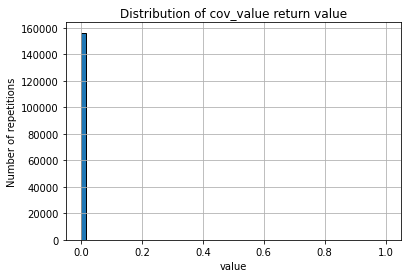

In [28]:
data, return_values = get_repeteated_data(['log_64-aa', 'log_64-ab'])
plot_reapeated_data_distribution(data)
plot_return_values_dist(return_values)

## Conclusiones de los parametros

**Parametros de gasdev**

- idum: siempre 0
- idum2: siempre 0
- iy: siempre 0

**Parametros de ran2**

- idum: siempre 0
- idum2: siempre 0
- iy: siempre 0

**Parametros de cov_value**

- di:
- dj:
- dk:

## Conclusiones de los valores de retorno

Parece ser que las 3 funciones tienen distribuciones bien marcadas:
- gasdev: es una normal(0, 500)
- ran2: uniforme(0,1)
- cov_value: parece solo devolver 0, sobre todo amedida que se agranda el tamaño del medio

# TODO

- [ ] Completar analisis de memoria y cpu
- [ ] Investigar mas el tema de llamadas a funciones repetidas (gasdev, cov_value, ran2)
- [ ] Escribir conclusiones (proximos pasos y cosas que no se consideran importantes)
- [X] Conseguir ayuda en tupac para poder correrlo